In [32]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from torchvision import datasets, transforms
import time
import statistics
import seaborn as sns
from pylab import savefig
import sklearn.metrics

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPool2D, Flatten, Dropout

In [2]:
mnist_training, mnist_testing = tf.keras.datasets.mnist.load_data()
training_data = np.float16(mnist_training[0])  # Returns np.array
training_labels = np.asarray(mnist_training[1], dtype=np.int32)
testing_data = np.float16(mnist_testing[0])  # Returns np.array
testing_labels = np.asarray(mnist_testing[1], dtype=np.int32)

training_data = training_data.reshape(len(training_data), 28*28)
testing_data = testing_data.reshape(len(testing_data), 28*28)

In [3]:
training_data = training_data.reshape(60000, 28, 28, 1)
testing_data = testing_data.reshape(10000, 28, 28, 1)

training_labels = tf.one_hot(training_labels.astype(np.int32), depth=10)
testing_labels = tf.one_hot(testing_labels.astype(np.int32), depth=10)

In [14]:
def repeatedTrainingAndTesting(model_name, dropout, batch_normalization, M):
    
    if batch_normalization and not(dropout):
        model = Sequential([
            BatchNormalization(),
            Conv2D(32, (6,6), padding='same', activation='relu', input_shape=(28, 28, 1)),
            Conv2D(32, (6,6), padding='same', activation='relu'),
            MaxPool2D(),
            BatchNormalization(),
            Conv2D(64, (4,4), padding='same', activation='relu'),
            MaxPool2D(strides=(2,2)),
            Flatten(),
            BatchNormalization(),
            Dense(128, activation='relu'),
            Dense(10, activation='softmax')
        ]);
        
    elif not(batch_normalization) and dropout:
        model = Sequential([
            Conv2D(32, (6,6), padding='same', activation='relu', input_shape=(28, 28, 1)),
            Conv2D(32, (6,6), padding='same', activation='relu'),
            MaxPool2D(),
            Dropout(0.25),
            Conv2D(64, (4,4), padding='same', activation='relu'),
            MaxPool2D(strides=(2,2)),
            Dropout(0.25),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(10, activation='softmax')
        ]);
        
    elif not(batch_normalization) and not(dropout):
        model = Sequential([
            Conv2D(32, (6,6), padding='same', activation='relu', input_shape=(28, 28, 1)),
            Conv2D(32, (6,6), padding='same', activation='relu'),
            MaxPool2D(),
            Conv2D(64, (4,4), padding='same', activation='relu'),
            MaxPool2D(strides=(2,2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dense(10, activation='softmax')
        ]);
          
    elif batch_normalization and dropout:
        model = Sequential([
            BatchNormalization(),
            Conv2D(32, (6,6), padding='same', activation='relu', input_shape=(28, 28, 1)),
            Conv2D(32, (6,6), padding='same', activation='relu'),
            MaxPool2D(),
            Dropout(0.25),
            BatchNormalization(),
            Conv2D(64, (4,4), padding='same', activation='relu'),
            MaxPool2D(strides=(2,2)),
            Dropout(0.25),
            Flatten(),
            BatchNormalization(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(10, activation='softmax')
        ]);
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    
    accuracies = []
    bestModel = None
    
    for i in range(M):
        
        totalTime = 0
        
        print('_______________________________________________________________________ M='+str(i+1))
        
        # TRAIN
        start_time = time.time()
        history = model.fit(training_data, training_labels, batch_size=128, epochs=5)
        end_time = time.time()
        duration = end_time - start_time
        print("Training time: --- %s seconds ---" % (duration))
        totalTime += duration
        
        # TEST
        loss, accuracy_score = model.evaluate(testing_data, testing_labels)
        print("Testing Accuracy: {0:f}%\n".format(accuracy_score*100))
        accuracies.append(accuracy_score)
        
        
        if accuracy_score == max(accuracies):
            bestModel = model
        
    return (totalTime, bestModel)

In [22]:
def evaluate(bestModel, fileName):
    
    Y_pred = bestModel.predict(testing_data)
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    Y_true = np.argmax(testing_labels,axis = 1)
    confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes) 
    
    f1 = sklearn.metrics.f1_score(Y_true, Y_pred_classes, average='weighted')
    accuracy = sklearn.metrics.accuracy_score(Y_true, Y_pred_classes)

    plt.figure(figsize=(10, 8))
    svm = sns.heatmap(confusion_mtx, annot=True, fmt='g')
    figure = svm.get_figure()   
    figure.savefig(fileName)
    
    return (f1, accuracy)

# CNN

In [23]:
m = 6

## With Dropout, With Batch-Normalization

_______________________________________________________________________ M=1
Epoch 1/5
469/469 [==============================] - 307s 652ms/step - loss: 0.4957 - accuracy: 0.8557
Epoch 2/5
469/469 [==============================] - 303s 647ms/step - loss: 0.0957 - accuracy: 0.9724
Epoch 3/5
469/469 [==============================] - 304s 649ms/step - loss: 0.0717 - accuracy: 0.9788
Epoch 4/5
469/469 [==============================] - 307s 654ms/step - loss: 0.0667 - accuracy: 0.9804
Epoch 5/5
469/469 [==============================] - 311s 664ms/step - loss: 0.0504 - accuracy: 0.9850
Training time: --- 1533.5076231956482 seconds ---
313/313 [==============================] - 11s 35ms/step - loss: 0.0294 - accuracy: 0.9913
Testing Accuracy: 99.129999%

_______________________________________________________________________ M=2
Epoch 1/5
469/469 [==============================] - 305s 650ms/step - loss: 0.0499 - accuracy: 0.9852
Epoch 2/5
469/469 [==============================] - 307s 6

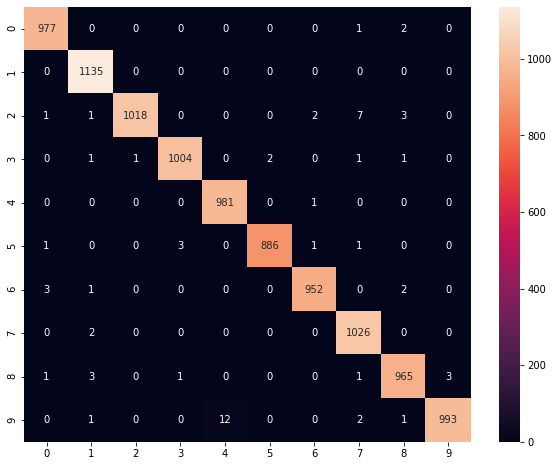

In [17]:
(time_DO_BN, bestModel_DO_BN) = repeatedTrainingAndTesting(model_name = "cnn_DO_BN", dropout = True, batch_normalization = True, M=m)
(top_f1_DO_BN, top_accuracy_DO_BN) = evaluate(bestModel_DO_BN, 'outputs/CNN_heatmap_DO_BN.png')

# Without Dropout, With Batch-Normalization

[[4.5154347e-19 6.1069186e-21 2.7662388e-26 ... 1.0000000e+00
  2.9501516e-21 1.7598078e-15]
 [2.9350992e-28 1.4895156e-26 1.0000000e+00 ... 2.2534048e-31
  7.5221155e-33 0.0000000e+00]
 [1.6375928e-18 1.0000000e+00 2.5885631e-23 ... 9.2289355e-22
  9.5550798e-14 7.6543743e-32]
 ...
 [0.0000000e+00 1.6886885e-38 0.0000000e+00 ... 0.0000000e+00
  4.4615847e-27 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  4.4318048e-24 1.4106196e-29]
 [4.1993967e-29 8.6945072e-33 6.2984915e-28 ... 2.5028266e-35
  3.9794522e-25 2.5470575e-33]]
tf.Tensor(
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(10000, 10), dtype=float32)


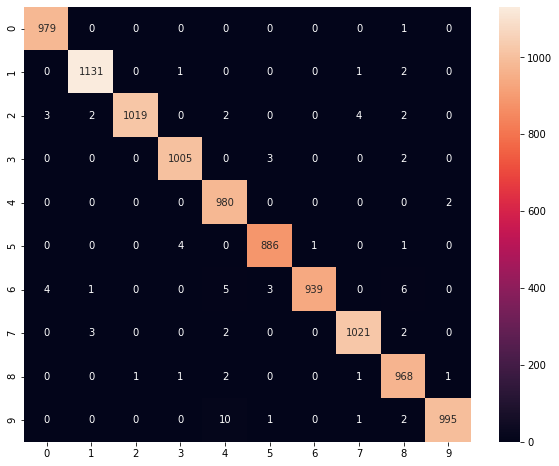

In [108]:
#(time_BN, bestModel_BN) = repeatedTrainingAndTesting(model_name = "cnn_BN", dropout = False, batch_normalization = True, M=m)
(top_f1_BN, top_accuracy_BN) = evaluate(bestModel_BN, 'outputs/CNN_heatmap_BN.png')

# With Dropout, Without Batch-Normalization

_______________________________________________________________________ M=1
Epoch 1/5
469/469 [==============================] - 284s 604ms/step - loss: 2.4549 - accuracy: 0.5131
Epoch 2/5
469/469 [==============================] - 281s 598ms/step - loss: 0.3022 - accuracy: 0.9030
Epoch 3/5
469/469 [==============================] - 283s 604ms/step - loss: 0.2127 - accuracy: 0.9343
Epoch 4/5
469/469 [==============================] - 283s 603ms/step - loss: 0.1532 - accuracy: 0.9555
Epoch 5/5
469/469 [==============================] - 283s 603ms/step - loss: 0.1243 - accuracy: 0.9637
Training time: --- 1414.0337550640106 seconds ---
313/313 [==============================] - 10s 30ms/step - loss: 0.0475 - accuracy: 0.9864
Testing Accuracy: 98.640001%

_______________________________________________________________________ M=2
Epoch 1/5
469/469 [==============================] - 283s 603ms/step - loss: 0.1036 - accuracy: 0.9705
Epoch 2/5
469/469 [==============================] - 283s 6

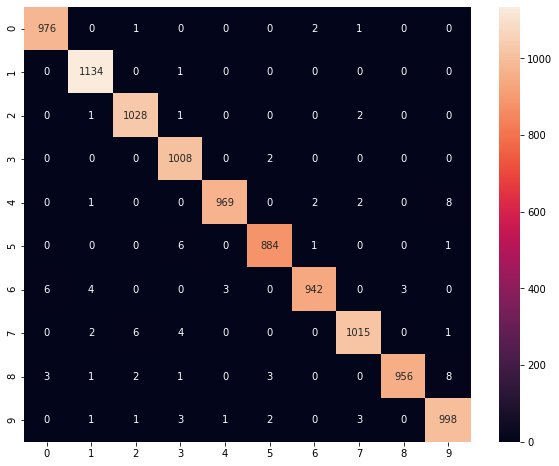

In [19]:
(time_DO, bestModel_DO) = repeatedTrainingAndTesting(model_name = "cnn_DO", dropout = True, batch_normalization = False, M=m)
(top_f1_DO, top_accuracy_DO) = evaluate(bestModel_DO, 'outputs/CNN_heatmap_DO.png')

# Without Dropout, Without Batch-Normalization

_______________________________________________________________________ M=1
Epoch 1/5
469/469 [==============================] - 274s 582ms/step - loss: 2.1471 - accuracy: 0.8116
Epoch 2/5
469/469 [==============================] - 275s 585ms/step - loss: 0.0473 - accuracy: 0.9856
Epoch 3/5
469/469 [==============================] - 282s 600ms/step - loss: 0.0306 - accuracy: 0.9899
Epoch 4/5
469/469 [==============================] - 278s 594ms/step - loss: 0.0264 - accuracy: 0.9911
Epoch 5/5
469/469 [==============================] - 275s 586ms/step - loss: 0.0213 - accuracy: 0.9932
Training time: --- 1383.4849944114685 seconds ---
313/313 [==============================] - 10s 30ms/step - loss: 0.0446 - accuracy: 0.9878
Testing Accuracy: 98.780000%

_______________________________________________________________________ M=2
Epoch 1/5
469/469 [==============================] - 275s 586ms/step - loss: 0.0220 - accuracy: 0.9924
Epoch 2/5
469/469 [==============================] - 278s 5

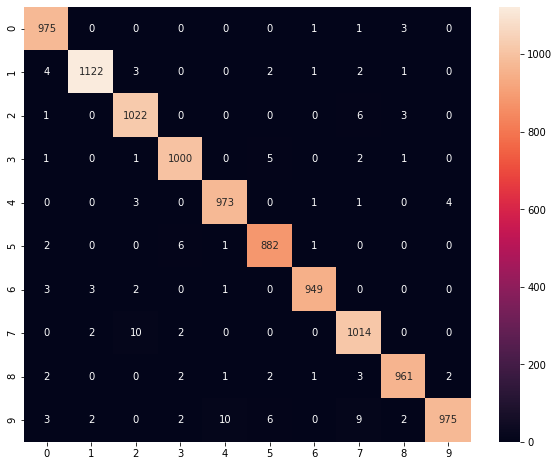

In [20]:
(time_none, bestModel_none) = repeatedTrainingAndTesting(model_name = "cnn_none", dropout = False, batch_normalization = False, M=m)
(top_f1_none, top_accuracy_none) = evaluate(bestModel_none, 'outputs/CNN_heatmap_none.png')

# Save Results

In [109]:
data = {'Accuracy_DO_BN': top_accuracy_DO_BN, 'Time_DO_BN': time_DO_BN,'F1_DO_BN': top_f1_DO_BN,
        'Accuracy_BN' : top_accuracy_BN, 'Time_BN' : time_BN, 'F1_BN': top_f1_BN,
        'Accuracy_DO' : top_accuracy_DO, 'Time_DO': time_DO, 'F1_DO': top_f1_DO, 
        'Accuracy_NONE': top_accuracy_none, 'Time_NONE': time_none, 'F1_NONE' : top_f1_none}

df = pd.DataFrame(data, index=[0])

df.to_csv('outputs/CNN.csv')

# MODEL COMPARISON (TRAINING LOSS GRAPHS)

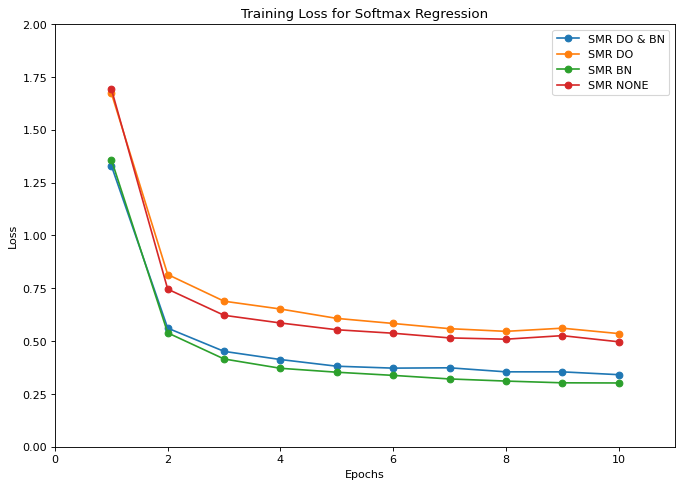

In [104]:
trainingLoss_df = pd.read_csv("outputs/TrainingLoss.csv", index_col=0)

figure(figsize=(10, 7), dpi=80)

epochs_range = [i+1 for i in range(10)]

plt.plot(epochs_range, trainingLoss_df.loc[:,'SMR_DO_BN'], '-o', label='SMR DO & BN')
plt.plot(epochs_range, trainingLoss_df.loc[:,'SMR_DO'], '-o', label='SMR DO')
plt.plot(epochs_range, trainingLoss_df.loc[:,'SMR_BN'], '-o', label='SMR BN')
plt.plot(epochs_range, trainingLoss_df.loc[:,'SMR_NONE'], '-o', label='SMR NONE')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0, 2.0])
plt.xlim([0, 11])
plt.title('Training Loss for Softmax Regression')
plt.legend()
plt.savefig('outputs/SMR_TrainingLoss.png')

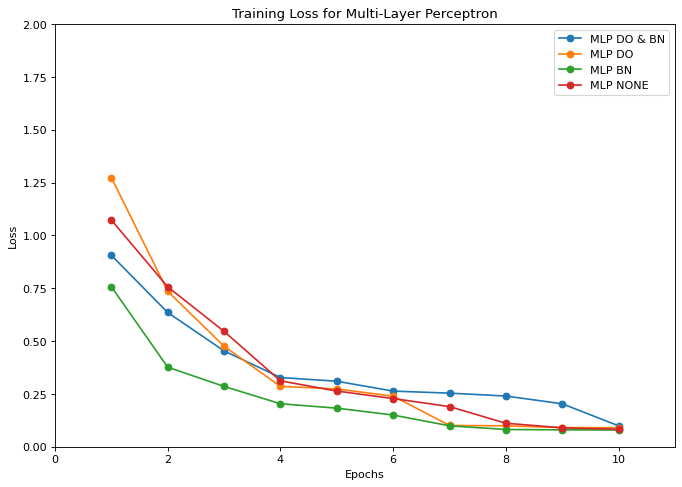

In [105]:
trainingLoss_df = pd.read_csv("outputs/TrainingLoss.csv", index_col=0)

figure(figsize=(10, 7), dpi=80)

epochs_range = [i+1 for i in range(10)]

plt.plot(epochs_range, trainingLoss_df.loc[:,'MLP_DO_BN'], '-o', label='MLP DO & BN')
plt.plot(epochs_range, trainingLoss_df.loc[:,'MLP_DO'], '-o', label='MLP DO')
plt.plot(epochs_range, trainingLoss_df.loc[:,'MLP_BN'], '-o', label='MLP BN')
plt.plot(epochs_range, trainingLoss_df.loc[:,'MLP_NONE'], '-o', label='MLP NONE')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0, 2.0])
plt.xlim([0, 11])
plt.title('Training Loss for Multi-Layer Perceptron')
plt.legend()
plt.savefig('outputs/MLP_TrainingLoss.png')

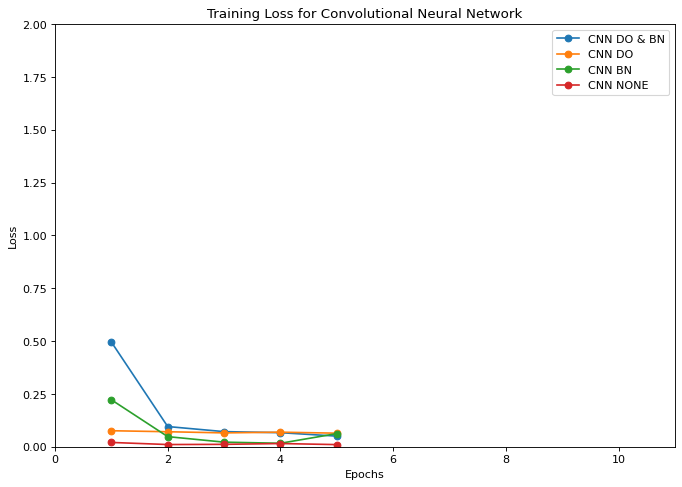

In [106]:
trainingLoss_df = pd.read_csv("outputs/TrainingLoss.csv", index_col=0)

figure(figsize=(10, 7), dpi=80)

epochs_range_CNN = [i+1 for i in range(5)]


plt.plot(epochs_range_CNN, trainingLoss_df.loc[0:4,'CNN_DO_BN'], '-o', label='CNN DO & BN')
plt.plot(epochs_range_CNN, trainingLoss_df.loc[0:4,'CNN_DO'], '-o', label='CNN DO')
plt.plot(epochs_range_CNN, trainingLoss_df.loc[0:4,'CNN_BN'], '-o', label='CNN BN')
plt.plot(epochs_range_CNN, trainingLoss_df.loc[0:4,'CNN_NONE'], '-o', label='CNN NONE')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0, 2.0])
plt.xlim([0, 11])
plt.title('Training Loss for Convolutional Neural Network')
plt.legend()
plt.savefig('outputs/CNN_TrainingLoss.png')